In [1]:
import numpy as np
import pandas as pd
import regex
import re
from PIL import Image
import torch
from torchvision.transforms import v2
from tqdm import tqdm
import os

from collections import Counter
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib


In [2]:
# config에서 data 폴더 경로 가져오기
data_dir = "/data/ephemeral/home/data"  # 예: "config/data"

# users.csv 경로 만들기
user_data_path = os.path.join(data_dir, "users.csv")
user_df = pd.read_csv(user_data_path)

book_data_path = os.path.join(data_dir, "books.csv")
book_df = pd.read_csv(book_data_path)

train_rating_data_path = os.path.join(data_dir, "train_ratings.csv")
train_rating_df = pd.read_csv(train_rating_data_path)

In [4]:
full_df = train_rating_df.merge(
    user_df,
    on="user_id",
    how="left"
)

# -----------------------
# 5. Merge: book 정보 추가
# -----------------------
full_df = full_df.merge(
    book_df,
    on="isbn",
    how="left"
)

print("Full DF shape:", full_df.shape)
print(full_df.head())

Full DF shape: (306795, 14)
   user_id        isbn  rating                   location   age    book_title  \
0        8  0002005018       4   timmins, ontario, canada   NaN  Clara Callan   
1    67544  0002005018       7   toronto, ontario, canada  30.0  Clara Callan   
2   123629  0002005018       8  kingston, ontario, canada   NaN  Clara Callan   
3   200273  0002005018       8    comber, ontario, canada   NaN  Clara Callan   
4   210926  0002005018       9    guelph, ontario, canada   NaN  Clara Callan   

            book_author  year_of_publication              publisher  \
0  Richard Bruce Wright               2001.0  HarperFlamingo Canada   
1  Richard Bruce Wright               2001.0  HarperFlamingo Canada   
2  Richard Bruce Wright               2001.0  HarperFlamingo Canada   
3  Richard Bruce Wright               2001.0  HarperFlamingo Canada   
4  Richard Bruce Wright               2001.0  HarperFlamingo Canada   

                                             img_url langu

In [16]:
df = full_df.copy()

# 둘 다 결측인지 확인
both_null = df[df['summary'].isna() & df['category'].isna()]

# summary만 결측
summary_only = df[df['summary'].isna() & df['category'].notna()]

# category만 결측
category_only = df[df['category'].isna() & df['summary'].notna()]

print("둘 다 결측:", len(both_null))
print("summary만 결측:", len(summary_only))
print("category만 결측:", len(category_only))


둘 다 결측: 119084
summary만 결측: 0
category만 결측: 2137


### book_popularity

In [15]:
import pandas as pd
import numpy as np

# ==========================================
# 1. 책 단위 기본 통계
# ==========================================
book_stats = (
    full_df.groupby("isbn")
    .agg(
        count=("rating", "size"),
        mean_rating=("rating", "mean")
    )
    .reset_index()
)

# ==========================================
# 2. Bayesian Average Popularity
# ==========================================

# 전체 평균 평점
C = full_df["rating"].mean()

# smoothing factor (보통 상위 60% 책들이 지나가는 count 값)
# m = book_stats["count"].quantile(0.60)
m = 30

v = book_stats["count"]
R = book_stats["mean_rating"]

book_stats["pop_bayesian"] = (v/(v+m)) * R + (m/(v+m)) * C

# ==========================================
# 3. 최종 popularity feature
# ==========================================
book_popularity = book_stats[[
    "isbn", 
    "count",
    "mean_rating",
    "pop_bayesian"
]]

print(book_popularity.head())

# full_df에 merge
full_df = full_df.merge(book_popularity, on="isbn", how="left")



         isbn  count  mean_rating  pop_bayesian
0  0000913154      1          8.0      7.099724
1  000104687X      1          6.0      7.035207
2  0001047213      1          8.0      7.099724
3  0001047973      2          9.0      7.190357
4  000104799X      1          6.0      7.035207


MergeError: Passing 'suffixes' which cause duplicate columns {'pop_bayesian_x', 'count_x', 'mean_rating_x'} is not allowed.

In [21]:
def get_top_popular_books(book_popularity_df, book_df, top_n=20):
    """
    베이지안 popularity 점수를 기준으로 가장 유명한 책 TOP N을 반환
    """
    # 1. 상위 N개 책 선택
    top_books = (
        book_popularity_df
        .sort_values("pop_bayesian", ascending=False)
        .head(top_n)
    ).copy()

    # 2. title/category 등 메타데이터 붙이기
    top_books = top_books.merge(
        book_df[['isbn', 'book_title', 'category', 'summary']],
        on='isbn',
        how='left'
    )

    return top_books


In [27]:
top_books = get_top_popular_books(full_df, book_df, top_n=20)
print(top_books[['isbn', 'count', 'mean_rating', 'pop_bayesian']])


          isbn  count  mean_rating  pop_bayesian
0   0439139597    109     9.155963      8.705694
1   0439139597    109     9.155963      8.705694
2   0439139597    109     9.155963      8.705694
3   0439139597    109     9.155963      8.705694
4   0439139597    109     9.155963      8.705694
5   0439139597    109     9.155963      8.705694
6   0439139597    109     9.155963      8.705694
7   0439139597    109     9.155963      8.705694
8   0439139597    109     9.155963      8.705694
9   0439139597    109     9.155963      8.705694
10  0439139597    109     9.155963      8.705694
11  0439139597    109     9.155963      8.705694
12  0439139597    109     9.155963      8.705694
13  0439139597    109     9.155963      8.705694
14  0439139597    109     9.155963      8.705694
15  0439139597    109     9.155963      8.705694
16  0439139597    109     9.155963      8.705694
17  0439139597    109     9.155963      8.705694
18  0439139597    109     9.155963      8.705694
19  0439139597    10

### 출판연도와 rating

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_rating_by_publication_year(rating_df, book_df):
    # merge
    df = rating_df.merge(
        book_df[['isbn', 'year_of_publication']],
        on='isbn',
        how='left'
    ).copy()

    # ---- 출판연도 전처리 ----
    df['year_of_publication'] = pd.to_numeric(df['year_of_publication'], errors='coerce')

    # 비정상적인 연도 제거
    df = df[(df['year_of_publication'] >= 1800) & (df['year_of_publication'] <= 2025)]

    # GroupBy 연도별 통계
    year_stats = df.groupby('year_of_publication').agg(
        mean_rating=('rating', 'mean'),
        count=('rating', 'count'),
        median_rating=('rating', 'median'),
        std_rating=('rating', 'std')
    ).reset_index()

    return year_stats


In [29]:
year_stats = analyze_rating_by_publication_year(train_rating_df, book_df)
print(year_stats.head())


   year_of_publication  mean_rating  count  median_rating  std_rating
0               1900.0         6.00      1            6.0         NaN
1               1901.0         7.25      4            8.0    2.986079
2               1902.0         6.00      2            6.0    1.414214
3               1904.0        10.00      1           10.0         NaN
4               1906.0         3.00      1            3.0         NaN


정상 출판년도 범위: 1981 ~ 2013
필터링 후 데이터: (295326, 4)


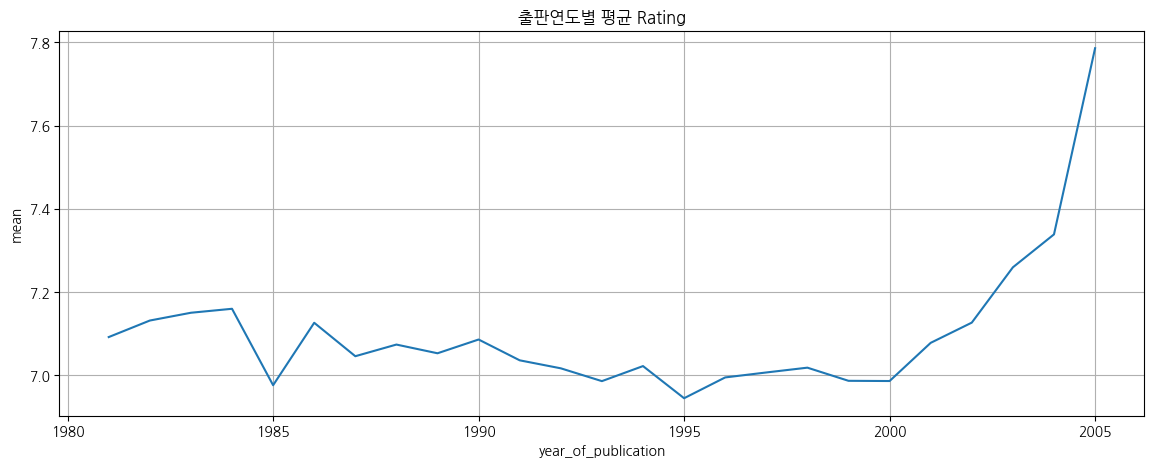

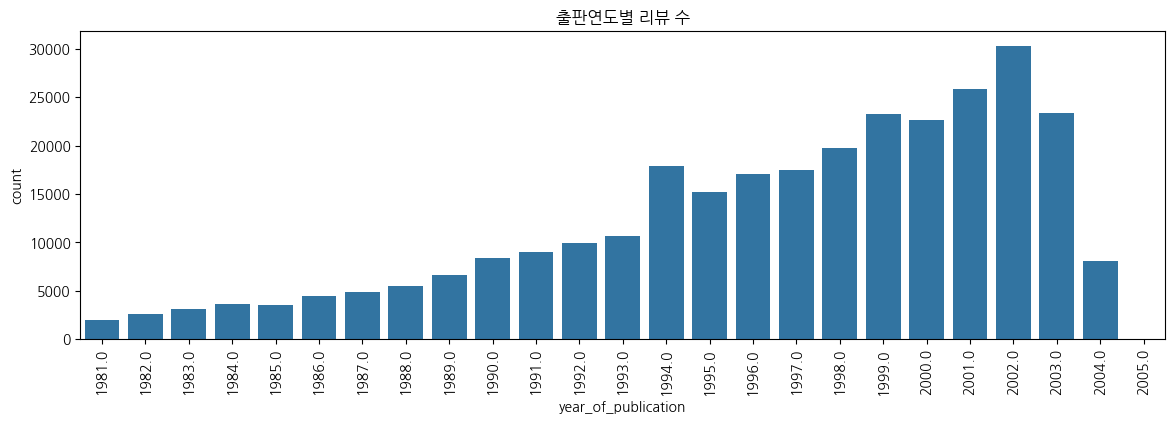

=== 상관 분석 ===
Pearson correlation : 0.011900720547045395  (p = 9.962575170243345e-11 )
Spearman correlation: 0.016262060212976097  (p = 9.745993180200255e-19 )
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     41.83
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           9.96e-11
Time:                        20:07:21   Log-Likelihood:            -6.8143e+05
No. Observations:              295326   AIC:                         1.363e+06
Df Residuals:                  295324   BIC:                         1.363e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err         

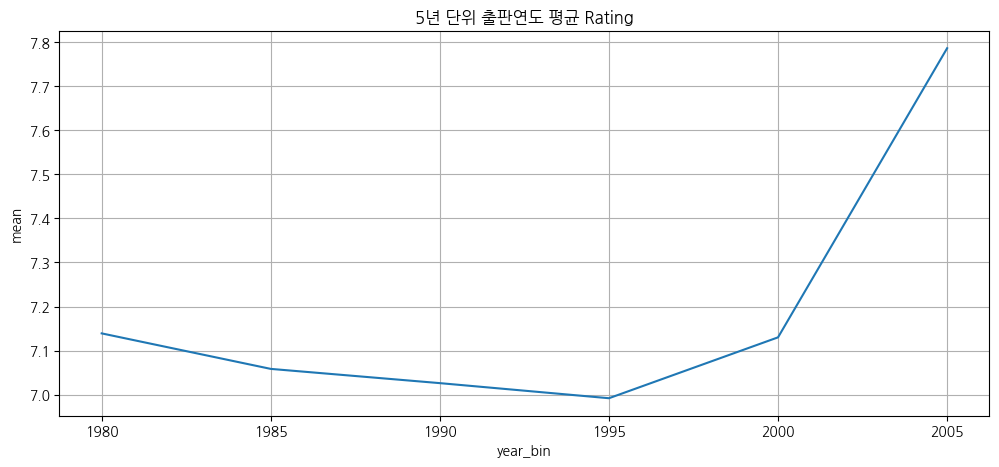



📌 자동 해석 리포트

1) 출판연도와 rating의 Spearman 상관계수 = 0.0163
   → 출판연도가 최근일수록 평점이 높아집니다 🔼
2) Spearman p-value < 0.05 → 단조 관계가 통계적으로 유의합니다.
3) 회귀 계수 = 0.0053 → 최근 책일수록 평균 rating 상승 경향

4) 5년 binning 결과도 함께 보면, 연도별 평점 변화가 더 안정적으로 보이며
   연도 단위 변동보다 '세대 단위' 변동이 더 의미 있는 패턴입니다.

5) 결론적으로 year_of_publication은 rating 예측에 유용한 feature이며,
   다음과 같이 변형 사용을 권장합니다:
   - book_age = 2025 - year_of_publication
   - log_age = log1p(book_age)
   - age_bin = book_age // 5



In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

# ============================================
# 0. 데이터 준비
# ============================================
df = train_rating_df.merge(
    book_df[['isbn', 'year_of_publication']],
    on='isbn', how='left'
)

df['year_of_publication'] = pd.to_numeric(df['year_of_publication'], errors='coerce')


# ============================================
# 1. 비정상값 제거 (이상연도 필터링)
# ============================================
Q1, Q3 = df['year_of_publication'].quantile([0.25, 0.75])
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR   # 1991 - 1.5*9 = 1977
upper = Q3 + 1.5 * IQR   # 2000 + 1.5*9 = 2014

df_clean = df[(df['year_of_publication'] >= lower) & (df['year_of_publication'] <= upper)].copy()

print("정상 출판년도 범위:", int(lower), "~", int(upper))
print("필터링 후 데이터:", df_clean.shape)


# ============================================
# 2. 출판연도 vs 평균 평점 Line Plot
# ============================================
year_stats = df_clean.groupby("year_of_publication")["rating"].agg(["mean", "count"]).reset_index()

plt.figure(figsize=(14,5))
sns.lineplot(data=year_stats, x="year_of_publication", y="mean")
plt.title("출판연도별 평균 Rating")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,4))
sns.barplot(data=year_stats, x="year_of_publication", y="count")
plt.title("출판연도별 리뷰 수")
plt.xticks(rotation=90)
plt.show()


# ============================================
# 3. 상관관계 분석 (Pearson + Spearman)
# ============================================
pearson_corr, p1 = pearsonr(df_clean['year_of_publication'], df_clean['rating'])
spearman_corr, p2 = spearmanr(df_clean['year_of_publication'], df_clean['rating'])

print("=== 상관 분석 ===")
print("Pearson correlation :", pearson_corr, " (p =", p1, ")")
print("Spearman correlation:", spearman_corr, " (p =", p2, ")")


# ============================================
# 4. 단순 선형 회귀 (연도 → 평점)
# ============================================
X = sm.add_constant(df_clean['year_of_publication'])
model = sm.OLS(df_clean['rating'], X).fit()

print(model.summary())


# ============================================
# 5. 5년 단위 binning 분석 (더 안정된 추세)
# ============================================
df_clean['year_bin'] = (df_clean['year_of_publication'] // 5) * 5
bin_stats = df_clean.groupby("year_bin")["rating"].agg(["mean", "count"])

print("\n\n=== 5년 단위 출판연도 Bin 분석 ===")
print(bin_stats)

plt.figure(figsize=(12,5))
sns.lineplot(data=bin_stats.reset_index(), x="year_bin", y="mean")
plt.title("5년 단위 출판연도 평균 Rating")
plt.grid(True)
plt.show()


# ============================================
# 6. 자동 해석 리포트 출력
# ============================================
print("\n\n===============================")
print("📌 자동 해석 리포트")
print("===============================\n")

# 방향성
direction = "높아집니다 🔼" if spearman_corr > 0 else "낮아집니다 🔽"

print(f"1) 출판연도와 rating의 Spearman 상관계수 = {spearman_corr:.4f}")
print(f"   → 출판연도가 최근일수록 평점이 {direction}")

# 유의성
if p2 < 0.05:
    print("2) Spearman p-value < 0.05 → 단조 관계가 통계적으로 유의합니다.")
else:
    print("2) p-value가 높아 유의하지 않습니다. (관계 약함)")

coef = model.params['year_of_publication']
if coef > 0:
    print(f"3) 회귀 계수 = {coef:.4f} → 최근 책일수록 평균 rating 상승 경향")
else:
    print(f"3) 회귀 계수 = {coef:.4f} → 오래된 책일수록 rating 상승 경향")

print("\n4) 5년 binning 결과도 함께 보면, 연도별 평점 변화가 더 안정적으로 보이며\n"
      "   연도 단위 변동보다 '세대 단위' 변동이 더 의미 있는 패턴입니다.")

print("\n5) 결론적으로 year_of_publication은 rating 예측에 유용한 feature이며,\n"
      "   다음과 같이 변형 사용을 권장합니다:\n"
      "   - book_age = 2025 - year_of_publication\n"
      "   - log_age = log1p(book_age)\n"
      "   - age_bin = book_age // 5\n")


In [ ]:
df["book_age"] = 2025 - df["year_of_publication"]
